## 更进一步测试 2021-7-5

In [2]:
from matplotlib import pyplot as plt
from matplotlib import patches
from matplotlib import text as mtext
import numpy as np
import math
from matplotlib.transforms import Affine2D, Bbox
from matplotlib.textpath import TextPath
from matplotlib.patches import PathPatch,Rectangle,Circle

from collections import Counter

In [3]:
from format_utils import process_data

In [4]:
from Bio.Align import AlignInfo
from Bio.Seq import Seq
from Bio import motifs
from Bio import SeqIO
from Bio import AlignIO
import pandas as pd

def count_to_pfm(counts):
    df = pd.DataFrame(counts)
    total_counts = df.T.sum()
    df = (df.T / total_counts).T
    df = df.fillna(0)
    return (df.to_dict(orient='list'), total_counts.tolist()[0])

def calc_relative_information(pfm, n_occur, correction_type='approx'):
    """Calculate relative information matrix"""
    bases = list(pfm.keys())
    if correction_type == 'approx':
        info_matrix = calc_info_matrix(pfm, n_occur)
    else:
        info_matrix = calc_info_matrix(pfm, 'exact')
    relative_info = {
        base: [
            np.nan_to_num(prob * info)
            for prob, info in zip(pfm[base], info_matrix)
        ]
        for base in bases
    }
    return relative_info
    
infile = 'test2.samelen.fa'
data_type = 'fasta'
alignment = AlignIO.read(infile, data_type)
data = []
for aln in alignment:
    data.append([x for x in str(aln.seq)])
df = pd.DataFrame(data)
df_counts = df.apply(pd.value_counts, 0)
total = df_counts[[0]].sum()
df_counts = df_counts[df_counts.index != '-']
# Remove - from counts
counts_dict = df_counts.to_dict(orient='index')
counts = {}
for key, val in counts_dict.items():
    counts[key] = list(val.values())



In [6]:
#pfm,ic = process_data('./test2.samelen.fa',data_type='fasta')

In [5]:
color_map = {'A': '#009980',
        'C': '#59B3E6',
        'G': '#E69B04',
        'T': '#1A1A1A',
        'N': 'grey'}

In [6]:
#seqs = ['ATAACAGATACA','ATAACAGGTAFA','ATAACAGATACAX','ATAIOFXFAA','ATAJICJIEC','AJIFOEFJIE','AIJFOEOXFEF','AFJIOEJIOFX','JFIOEJOXKXIJF','TAAAAFFFFF']
seqs = []
with open('./test.fa','r') as inpf:
    for line in inpf:
        line = line.strip()
        if line[0] == '>':
            continue
        seqs.append(line)
seqs[:10]

['GTCGGCCCCGCACCTGCGGAGGCACCCC',
 'GTCTTCCCCATGTGCGTGGGGGTGTTTC',
 'GTTGAACCGTACCTATGAGAGAT',
 'CCTATGCCGACCCTTCTTTGGGGGTTGGCCGACAAC',
 'GTTCGCTGCCGCATAGGCAGCTAAGAAA',
 'CCGCCAAACCTCTGATGCCGCAAGGCTTTGAGCAC',
 'TGTTTTAGTGGATCTTGATCGCGAAT',
 'GGACTTCCCCCGCCCACGGGGATGATCCC',
 'CGACCCACCTCCGCTGGCGCGGAGAGCAC',
 'GTTTTAGTTTCTTTGAGTTGTTAC']

In [11]:
bigTable = {}
for seq_len in sorted(set([len(seq) for seq in seqs])):
    #print('seq_len: ',seq_len)
    curr_seqs = [seq for seq in seqs if len(seq) == seq_len]
    #print(curr_seqs)
    summary = {}
    for pos in range(seq_len):
        summary[pos] = {}
        for seq in curr_seqs:
            summary[pos][seq[pos]] = summary[pos].get(seq[pos],0) + 1
    bigTable[seq_len] = summary
#bigTable


seq_len  23
[0, 0]
seq_len  24
[0, 1.5]
seq_len  25
[0, 3.0]
seq_len  26
[0, 4.5]


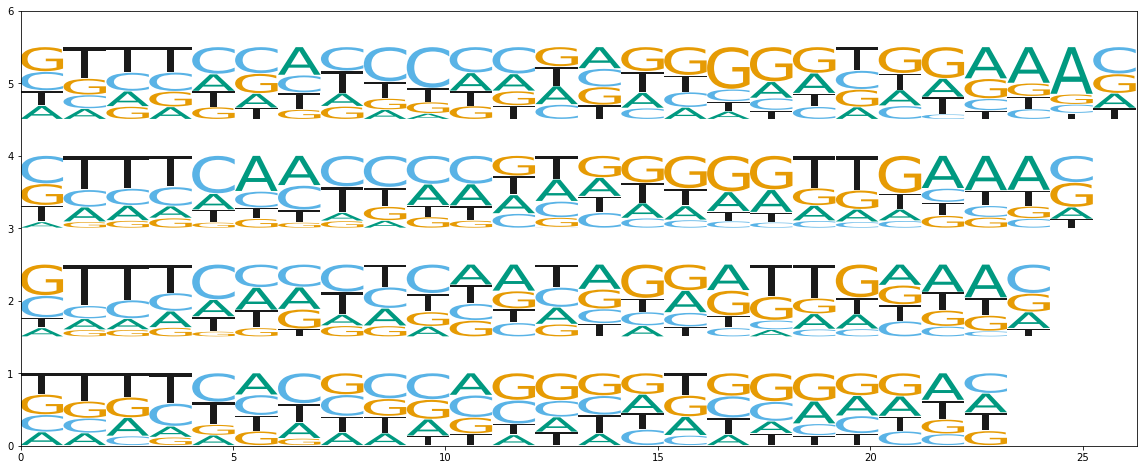

In [15]:
fig, ax = plt.subplots(1, 1,figsize=(20,8))

width = 1
height = 1
panel_vpad = 0.5
base_hpad = 0.01
base_vpad = 0.01

max_path = TextPath((0, 0), 'E', size=1)
maxbox = max_path.get_extents()
start_point = None
processed_seqlens = []
for seq_len in sorted(list(bigTable.keys())):
    if seq_len not in [23,24,25,26]:
        continue
    print('seq_len ',seq_len)
    processed_seqlens.append(seq_len)
    if not start_point:
        start_point = [0,0]
    else:
        start_point = [start_point[0],start_point[1]+height+panel_vpad]
    print(start_point)
    
    base_start = start_point.copy()
    j = -1
    for pos in sorted(list(bigTable[seq_len])):
        j += 1
        if j > 0:
            base_start[0] += width + base_hpad
        st = sorted(bigTable[seq_len][pos].items(),key=lambda d: d[1],reverse=True)
        pieces = sum([x[1] for x in st])
        i = -1
        floor = base_start[1] + height 
        for base,count in st:
            i += 1
            base_height = ((height-(len(st)*base_vpad))/pieces)*count
            floor -= base_height
            base_cor = [base_start[0],floor]
            #print(base,base_cor)
            tmp_path = TextPath((0,0), base, size=1)
            bbox = tmp_path.get_extents()
            hoffset = (width - bbox.width * width / max(bbox.width,maxbox.width))/2
            transformation = Affine2D() \
                .translate(tx=-bbox.xmin, ty=-bbox.ymin) \
                .scale(sx=width/max(bbox.width,maxbox.width), sy=base_height/bbox.height) \
                .translate(tx=base_cor[0] + hoffset,ty=base_cor[1])
            final_path = transformation.transform_path(tmp_path)

            patch = PathPatch(final_path,
                              facecolor=color_map[base],                              
                              alpha=1,
                              edgecolor=color_map[base],
                              linewidth=0)
            ax.add_patch(patch)
            #print(base,base_height)
            floor -= base_vpad
    
    


ax.set_xlim(0,max(processed_seqlens) + max(processed_seqlens)*base_hpad + base_hpad)
ax.set_ylim(0,len(processed_seqlens)+ len(processed_seqlens)*panel_vpad )
plt.show()

## 纵坐标用bits

In [8]:
ic_table = {}
seq_lens = sorted(set([len(seq) for seq in seqs]))
for seq_len in seq_lens:
    if seq_len > 27:
        continue
    with open('tmp/tmp.fa','w') as outpf:
        i = 0
        for seq in seqs:
            if len(seq) != seq_len:
                continue
            i += 1
            outpf.write(f'>seq{i}\n')
            outpf.write(seq + '\n')
    pfm,ic = process_data('./tmp/tmp.fa',data_type='fasta')
    ic_table[seq_len] = ic.copy()

/data1/chenyaowen/workspace/varylen_seqlogo/vllogo/format_utils.py:106: RuntimeWarning: divide by zero encountered in log2
  -pfm[b][l] * np.nan_to_num(np.log2(pfm[b][l])) for b in bases
/data1/chenyaowen/workspace/varylen_seqlogo/vllogo/format_utils.py:111: RuntimeWarning: divide by zero encountered in log2
  [pfm[b][l] * np.nan_to_num(np.log2(pfm[b][l])) for b in bases])


In [50]:
len(ic_table[24])

24

seq_len:  23
len of ic:  23
[0, 0]
max_ceiling:  0.2358868666480691
seq_len:  24
len of ic:  24
[0, 0.3358868666480691]
max_ceiling:  0.7605626077553852
seq_len:  25
len of ic:  25
[0, 0.8605626077553852]
max_ceiling:  1.2304397857629543
seq_len:  26
len of ic:  26
[0, 1.3304397857629544]
max_ceiling:  1.9451622476411257
seq_len:  27
len of ic:  27
[0, 2.0451622476411258]
max_ceiling:  2.893926754487202


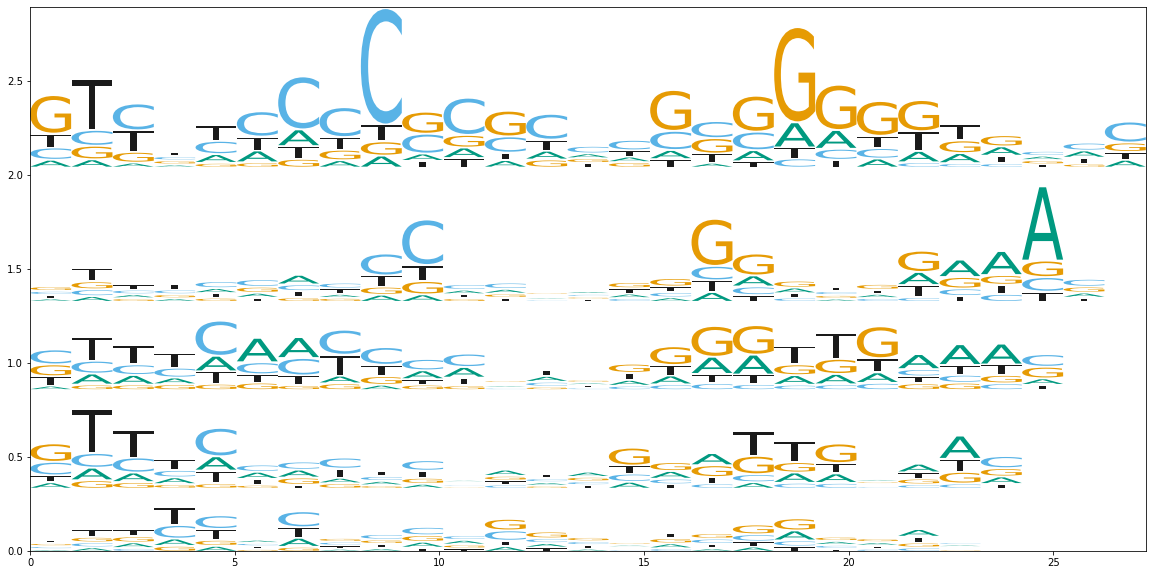

In [53]:
fig, ax = plt.subplots(1, 1,figsize=(20,10))

width = 1
panel_vpad = 0.1
base_hpad = 0.01
base_vpad = 0.01

max_path = TextPath((0, 0), 'E', size=1)
maxbox = max_path.get_extents()
start_point = None

for seq_len in sorted(list(ic_table.keys())):
    
    ic = ic_table[seq_len]
    print('seq_len: ',seq_len)
    print('len of ic: ',len(ic))
    if not start_point:
        start_point = [0,0]
    else:
        start_point = [start_point[0],max_ceiling+panel_vpad]
    print(start_point)
    
    base_start = start_point.copy()
    max_ceiling = -1
    j = -1
    for pos_arr in ic:
        j += 1
        if j > 0:
            base_start[0] += width + base_hpad
        i = -1
        floor = base_start[1] 
        st = sorted(pos_arr,key=lambda d:d[1])
        for base,bit in st:
            i += 1
            base_height = bit
            if bit < 0.001:
                continue
            base_cor = [base_start[0],floor]
            #print(base,base_cor)
            tmp_path = TextPath((0,0), base, size=1)
            bbox = tmp_path.get_extents()
            hoffset = (width - bbox.width * width / max(bbox.width,maxbox.width))/2
            transformation = Affine2D() \
                .translate(tx=-bbox.xmin, ty=-bbox.ymin) \
                .scale(sx=width/max(bbox.width,maxbox.width), sy=base_height/bbox.height) \
                .translate(tx=base_cor[0] + hoffset,ty=base_cor[1])
            final_path = transformation.transform_path(tmp_path)

            patch = PathPatch(final_path,
                              facecolor=color_map[base],                              
                              alpha=1,
                              edgecolor=color_map[base],
                              linewidth=0)
            ax.add_patch(patch)
            #print(base,base_height)
            floor += base_height + base_vpad
            if floor > max_ceiling:
                max_ceiling = floor
    print('max_ceiling: ',max_ceiling)    
    


ax.set_xlim(0,len(ic) + len(ic)*base_hpad )
ax.set_ylim(0, max_ceiling )
plt.show()

## 同心圆

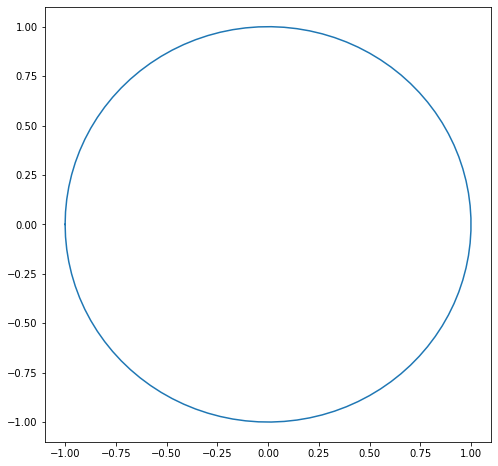

In [60]:
plt.figure(figsize=(8,8))
plt.plot(-np.cos(np.linspace(0,2*np.pi,100)),
 np.sin(np.linspace(0,2*np.pi,100)))

(-2.0, 2.0)

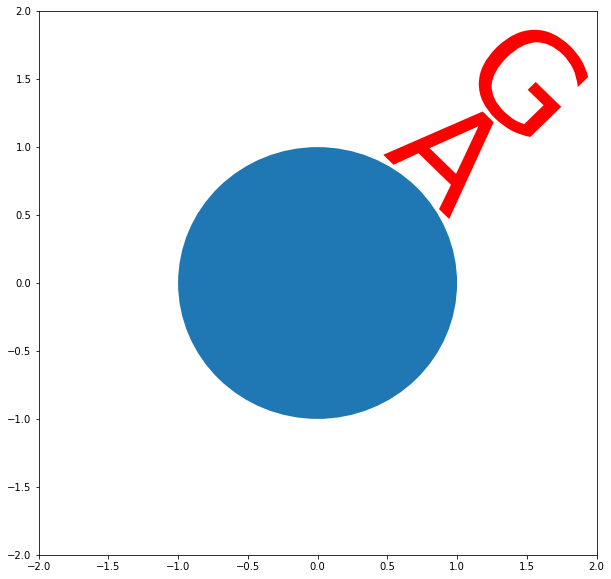

In [121]:
def angle_between(p1, p2=(0,0)):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return np.rad2deg((ang1 - ang2) % (2 * np.pi))

fig, ax = plt.subplots(1, 1,figsize=(10,10))
start = (0.7071067811865476, 0.7071067811865475)
#start = (-1,0)


ax.add_patch(Circle((0,0),1,linewidth=0))

tmp_path = TextPath((0,0), 'A', size=1)
bbox = tmp_path.get_extents()

transformation = Affine2D() \
        .translate(tx=-bbox.xmin, ty=-bbox.ymin) \
        .translate(tx=start[0] - bbox.width/2 ,ty=start[1])\
        .rotate_deg_around(start[0],start[1], angle_between(start)-90)
final_path = transformation.transform_path(tmp_path)

patch = PathPatch(final_path,
                  facecolor='r',                              
                  alpha=1,
                  edgecolor='r',
                  linewidth=0)
ax.add_patch(patch)


###################
tmp_path = TextPath((0,0), 'G', size=1)
bbox = tmp_path.get_extents()
start = (0.7071067811865476, 0.7071067811865475)


transformation = Affine2D() \
        .translate(tx=-bbox.xmin, ty=-bbox.ymin) \
        .translate(tx=start[0] - bbox.width/2 ,ty=start[1] + bbox.height)\
        .rotate_deg_around(start[0],start[1], angle_between(start)-90)
final_path = transformation.transform_path(tmp_path)

patch = PathPatch(final_path,
                  facecolor='r',                              
                  alpha=1,
                  edgecolor='r',
                  linewidth=0)
ax.add_patch(patch)


ax.set_xlim(-2,2)
ax.set_ylim(-2,2)

seq_len:  23
len of ic:  23
[0, 1]
max_ceiling:  0.7876605999442072
seq_len:  24
len of ic:  24
[0, 1.887660599944207]
max_ceiling:  1.3540272233219481
seq_len:  25
len of ic:  25
[0, 3.341687823266155]
max_ceiling:  1.3540272233219481
seq_len:  26
len of ic:  26
[0, 4.7957150465881035]
max_ceiling:  1.9241673856345138
seq_len:  27
len of ic:  27
[0, 6.8198824322226175]
max_ceiling:  2.6262935205382285


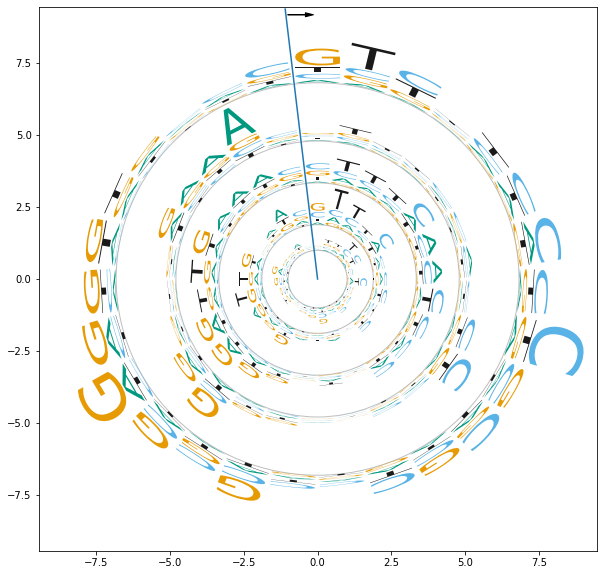

In [59]:
def angle_between(p1, p2=(0,0)):
    ang1 = np.arctan2(*p1[::-1])
    ang2 = np.arctan2(*p2[::-1])
    return (ang1 - ang2) % (2 * np.pi)

def get_coor_by_angle(radius,angle):
    return radius * np.cos(angle), radius * np.sin(angle)


fig, ax = plt.subplots(1, 1,figsize=(10,10))

max_path = TextPath((0, 0), 'E', size=1)
maxbox = max_path.get_extents()
panel_vpad = 0.1
base_vpad = 0.05
radius = 0
max_ceiling = 0
for seq_len in sorted(list(ic_table.keys())):
    
    ic = ic_table[seq_len]
    print('seq_len: ',seq_len)
    print('len of ic: ',len(ic))
    if radius == 0:
        radius = 1
    else:
        radius  += max_ceiling + panel_vpad

    start_point = [0,radius]
    print(start_point)

    ax.add_patch(Circle((0,0),radius,linewidth=1,fill=False,edgecolor='grey',alpha=0.5))

    #compute the width

    each_deg = 2*np.pi / len(ic)
    width = 2 * radius * np.tan(each_deg/2)
    width = width * 0.95

    degs = [x*each_deg + np.pi/2 for x in range(len(ic))]
    degs = degs[::-1]
    degs = [degs.pop()] + degs

    j = -1
    for pos_arr in ic:
        j += 1
        angle = degs[j]
        start = get_coor_by_angle(radius,angle)
        #if j == 0:
        #    plt.scatter(start[0],start[1])
        
        floor = 0  
        st = sorted(pos_arr,key=lambda d:d[1])
        
        i = -1
        for base,bit in st:
            i += 1
            base_height = bit*3
            if bit < 0.001:
                continue
            
            tmp_path = TextPath((0,0), base, size=1)
            bbox = tmp_path.get_extents()

            hoffset = (bbox.width * width / max(bbox.width,maxbox.width))/2

            transformation = Affine2D() \
                .translate(tx=-bbox.xmin, ty=-bbox.ymin) \
                .scale(sx=width/max(bbox.width,maxbox.width), sy=base_height/bbox.height) \
                .translate(tx=start[0] - hoffset ,ty=start[1] + floor)\
                .rotate_around(start[0],start[1], angle-np.pi/2)
            
            final_path = transformation.transform_path(tmp_path)

            patch = PathPatch(final_path,
                  facecolor=color_map[base],                              
                  alpha=1,
                  edgecolor=color_map[base],
                  linewidth=0)
            ax.add_patch(patch)

            #print(base,base_height)
            floor += base_height + base_vpad
            if floor > max_ceiling:
                max_ceiling = floor
    print('max_ceiling: ',max_ceiling)    

space_deg = degs[0] + (degs[-1] - degs[0])/2
space_radius = max_ceiling + radius
space_coor = get_coor_by_angle(space_radius,space_deg)
ax.plot([0,space_coor[0]],[0,space_coor[1]])

#ax.arrow(0, 8, 1, 8, head_width=0.05, head_length=0.1, fc='k', ec='k')
style = "Simple, tail_width=0.5, head_width=4, head_length=8"
kw = dict(arrowstyle=style, color="k")


arrow_coor = get_coor_by_angle(space_radius-2*panel_vpad,space_deg)
a = patches.FancyArrowPatch(arrow_coor, (arrow_coor[0]+1, arrow_coor[1]), **kw)
ax.add_patch(a)


fig_radius = max_ceiling + radius
ax.set_xlim(-1*fig_radius,fig_radius )
ax.set_ylim(-1*fig_radius,fig_radius )
plt.show()

In [145]:
#找到一个合适的半径，让字母的纵横比相对可靠，对于bits来说。。

## 扇形

[0.23561342740813127, 0.38298945338548374, 0.34057123710679704, 0.19327947319055455, 0.4176171438008087] 1.5700707348917753 1.5707963267948966
seq_len:  23
len of ic:  23
seq_len:  23
seq_len:  24
len of ic:  24
seq_len:  24
seq_len:  25
len of ic:  25
seq_len:  25
seq_len:  26
len of ic:  26
seq_len:  26
seq_len:  27
len of ic:  27
seq_len:  27


(0.0, 34.7)

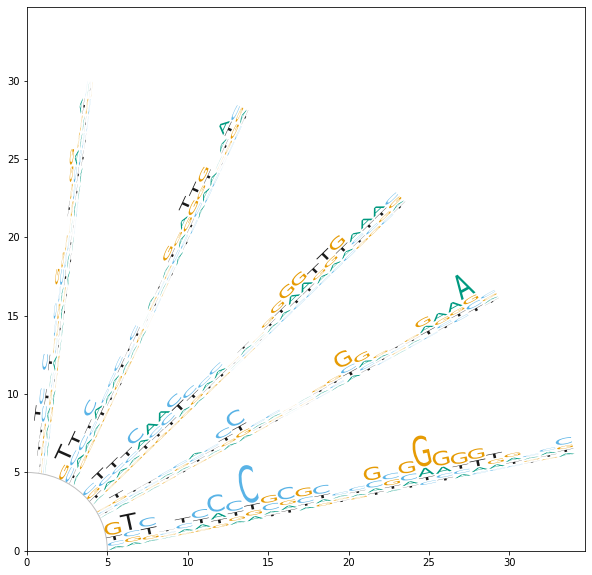

In [77]:
fig, ax = plt.subplots(1, 1,figsize=(10,10))

radius = 5
max_path = TextPath((0, 0), 'E', size=1)
maxbox = max_path.get_extents()
width = 1
base_vpad = 0.1
base_hpad = 0.1

#calculate degree
thetas = []
first_ceilings = []
max_ceilings = [] #only consider the first 5 chars
for seq_len in sorted(list(ic_table.keys())):
    ic = ic_table[seq_len]
    first_ceiling = sum([x[1] for x in ic[0] if x[1] >= 0.001])*4 + base_vpad*4
    max_ceiling = max([sum([x[1] for x in ic_pos if x[1] >= 0.001])*4 + base_vpad*4 for ic_pos in ic][:5])
    thetas.append(2*np.arctan(max_ceiling/(2*radius)))
    first_ceilings.append(first_ceiling)
    max_ceilings.append(max_ceiling)



print(thetas,sum(thetas),np.pi/2)

if sum(thetas) < np.pi/2:
    #print('enter')
    spacer = (np.pi/2 - sum(thetas))/2
    origin = (0,0)
    xlim = max([len(ic_table[x]) for x in ic_table])*(1 + base_hpad) + radius
    ylim = xlim
else:
    spacer = (np.pi - sum(thetas))/2
    origin = (0,ylim/2)
    xlim = 2*(max([len(ic_table[x]) for x in ic_table]) + radius)
    ylim = xlim

ax.add_patch(Circle(origin,radius,linewidth=1,fill=False,edgecolor='grey',alpha=0.5))


deg_pointer = spacer
degs = []
for index,theta in enumerate( thetas):
    c_deg = np.pi/2 - deg_pointer - theta/2
    deg_pointer += theta
    degs.append(c_deg)

   
seq_no = -1
for seq_len in sorted(list(ic_table.keys())):
    seq_no += 1
    ic = ic_table[seq_len]
    print('seq_len: ',seq_len)
    print('len of ic: ',len(ic))

    #if seq_no == 0:
    ##    start = get_coor_by_angle(1,np.pi/4)
    #    print(start)
    #    ax.scatter(start[0],start[1])
    start = [radius+origin[0],0+origin[1]]
    print('seq_len: ',seq_len)

    j = -1
    line_start = [start[0],start[1]]
    max_ceiling = max_ceilings[seq_no]
    first_ceiling = first_ceilings[seq_no]
    for pos_arr in ic:
        
        j += 1
        #print('pos: ',j)
        floor = line_start[1]
        st = sorted(pos_arr,key=lambda d:d[1])
        if j > 0 :
            line_start[0] += width + base_hpad

        
        i = -1
        for base,bit in st:
            i += 1
            #print('base: ',base)
            base_height = 4*bit
            if bit < 0.001:
                continue
            
            tmp_path = TextPath((0,0), base, size=1)
            bbox = tmp_path.get_extents()

            hoffset = (bbox.width * width / max(bbox.width,maxbox.width))/2

            transformation = Affine2D() \
                .translate(tx=-bbox.xmin, ty=-bbox.ymin) \
                .scale(sx=width/max(bbox.width,maxbox.width), sy=base_height/bbox.height) \
                .translate(tx=line_start[0], ty=floor - (max_ceiling-base_vpad)/2)\
                .rotate_around(origin[0],origin[1], degs[seq_no])
            
            #print(angle_between(start))
            
            final_path = transformation.transform_path(tmp_path)

            patch = PathPatch(final_path,
                  facecolor=color_map[base],                              
                  alpha=1,
                  edgecolor=color_map[base],
                  linewidth=0)
            ax.add_patch(patch)

            #print(base,base_height)
            floor += base_height + base_vpad
            #print('base_height,base_vpad,floor',base_height,base_vpad,floor)
        #print('floor: ',floor)




ax.set_xlim(0,xlim)
ax.set_ylim(0,ylim)


In [76]:
[len(ic_table[x]) for x in ic_table]

[23, 24, 25, 26, 27]

## 3D

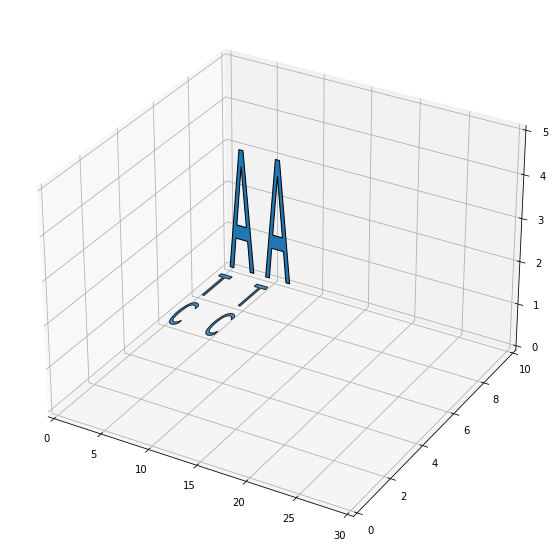

In [118]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, PathPatch
from matplotlib.text import TextPath
from matplotlib.transforms import Affine2D
import mpl_toolkits.mplot3d.art3d as art3d


def text3d(ax, xyz, s, zdir="z", size=None, angle=0, usetex=False, **kwargs):
    """
    Plots the string *s* on the axes *ax*, with position *xyz*, size *size*,
    and rotation angle *angle*. *zdir* gives the axis which is to be treated as
    the third dimension. *usetex* is a boolean indicating whether the string
    should be run through a LaTeX subprocess or not.  Any additional keyword
    arguments are forwarded to `.transform_path`.

    Note: zdir affects the interpretation of xyz.
    """
    x, y, z = xyz
    if zdir == "y":
        xy1, z1 = (x, z), y
    elif zdir == "x":
        xy1, z1 = (y, z), x
    else:
        xy1, z1 = (x, y), z

    text_path = TextPath((0, 0), s, size=size, usetex=usetex)
    trans = Affine2D().rotate(angle).translate(xy1[0], xy1[1])

    p1 = PathPatch(trans.transform_path(text_path), **kwargs)
    ax.add_patch(p1)
    art3d.pathpatch_2d_to_3d(p1, z=z1, zdir=zdir)


fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

# Draw a circle on the x=0 'wall'
#p = Circle((5, 5), 3)
#ax.add_patch(p)
#art3d.pathpatch_2d_to_3d(p, z=0, zdir="x")

# Manually label the axes
#text3d(ax, (4, -2, 0), "X-axis", zdir="z", size=.5, usetex=False,
#       ec="none", fc="k")
#text3d(ax, (12, 4, 2), "Y-axis", zdir="z", size=.5, usetex=False,
#       angle=np.pi / 2, ec="none", fc="k")
#text3d(ax, (12, 10, 4), "Z-axis", zdir="y", size=.5, usetex=False,
#       angle=np.pi / 2, ec="none", fc="k")

# Write a Latex formula on the z=0 'floor'
#text3d(ax, (1, 5, 5),
#       r"$\displaystyle G_{\mu\nu} + \Lambda g_{\mu\nu} = "
#       r"\frac{8\pi G}{c^4} T_{\mu\nu}  $",
##       zdir="z", size=1, usetex=True,
 #      ec="none", fc="k")

text3d(ax,(0,10,0),'A',size=4,zdir='y')
text3d(ax,(4,10,0),'A',size=4,zdir='y')

text3d(ax,(0,8,0),'T',size=2,zdir='z',alpha=0.8)
text3d(ax,(4,8,0),'T',size=2,zdir='z',alpha=0.8)

text3d(ax,(0,6,0),'C',size=2,zdir='z',alpha=0.8)
text3d(ax,(4,6,0),'C',size=2,zdir='z',alpha=0.8)

ax.set_xlim(0, 30)
ax.set_ylim(0, 10)
ax.set_zlim(0, 5)

plt.show()


seq_len:  23
len of ic:  23
[0, 34.7]


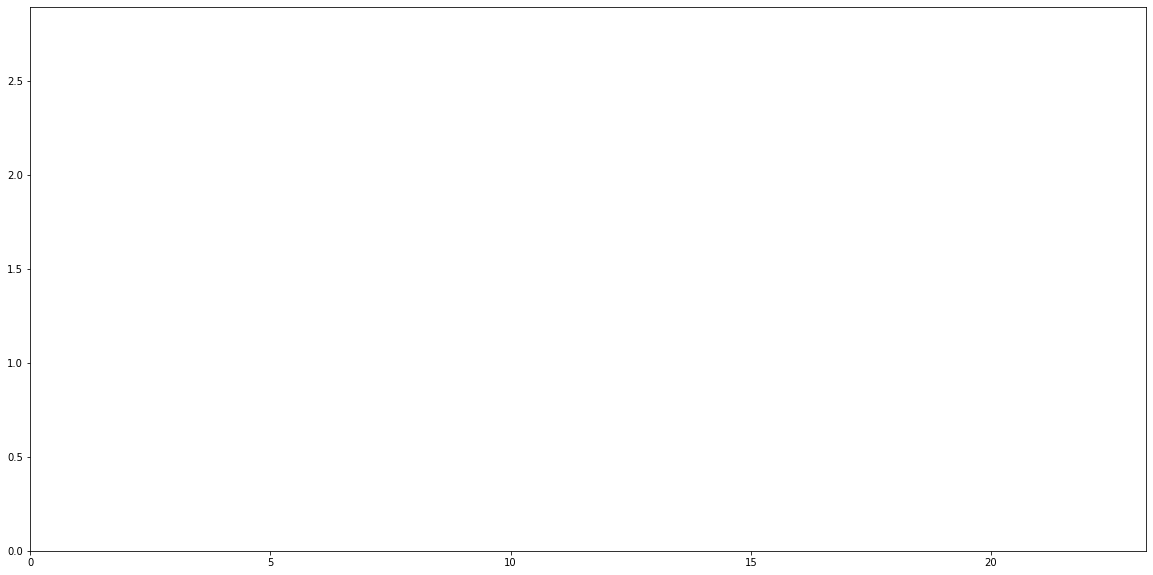

In [120]:
fig, ax = plt.subplots(1, 1,figsize=(20,10))

width = 1
panel_vpad = 0.1
base_hpad = 0.01
base_vpad = 0.01

max_path = TextPath((0, 0), 'E', size=1)
maxbox = max_path.get_extents()

start_point = None

for seq_len in sorted(list(ic_table.keys()))[:1]:
    
    ic = ic_table[seq_len]

    start_point = [0,ylim]
    print(start_point)
    
    base_start = start_point.copy()

    max_ceiling = -1
    j = -1
    for pos_arr in ic:
        j += 1
        if j > 0:
            base_start[0] += width + base_hpad
        i = -1
        floor = base_start[1] 
        st = sorted(pos_arr,key=lambda d:d[1])
        for base,bit in st:
            i += 1
            base_height = bit
            if bit < 0.001:
                continue
            if i == 0:



                
            base_cor = [base_start[0],floor]
            #print(base,base_cor)
            tmp_path = TextPath((0,0), base, size=1)
            bbox = tmp_path.get_extents()
            hoffset = (width - bbox.width * width / max(bbox.width,maxbox.width))/2
            transformation = Affine2D() \
                .translate(tx=-bbox.xmin, ty=-bbox.ymin) \
                .scale(sx=width/max(bbox.width,maxbox.width), sy=base_height/bbox.height) \
                .translate(tx=base_cor[0] + hoffset,ty=base_cor[1])
            final_path = transformation.transform_path(tmp_path)

            patch = PathPatch(final_path,
                              facecolor=color_map[base],                              
                              alpha=1,
                              edgecolor=color_map[base],
                              linewidth=0)
            ax.add_patch(patch)
            #print(base,base_height)
            floor += base_height + base_vpad
            if floor > max_ceiling:
                max_ceiling = floor
    print('max_ceiling: ',max_ceiling)    
    


ax.set_xlim(0,len(ic) + len(ic)*base_hpad )
ax.set_ylim(0, max_ceiling )
plt.show()